<a href="https://colab.research.google.com/github/Danial-sb/FakeNewsDetection/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
print(torch.__version__)

2.0.1+cu118


In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from torch_geometric.datasets import UPFD
import pandas as pd
import networkx as nx
from torch_geometric.loader import DataLoader
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_max_pool
from torch_geometric.nn import global_add_pool
from torch_geometric.nn import Node2Vec
from torch_geometric.nn.conv.gcn_conv import GCNConv
from torch_geometric.nn.conv import SAGEConv
from torch_geometric.nn.conv import GATConv
from torch_geometric.nn.models import GIN
from torch.nn import BatchNorm1d
import argparse
from sklearn.metrics import accuracy_score, f1_score
import copy
import matplotlib.pyplot as plt

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--model', type=str, choices=['gcn', 'mlp', 'sage', 'gat', 'gin'], default='gcn', help='which model to use (default: gcn)')
parser.add_argument('--batch_size', type=int, default=64, help='batch size')
parser.add_argument('--seed', type=int, default=1234, help='seed for reproducibility')
parser.add_argument('--hidden_channels', type=int, default=128, help='hidden channles of the layers')
parser.add_argument('--feature', type=str, default='content', help='feature type: [profile, spacy, bert, content]')
parser.add_argument('--lr', type=float, default=0.01, help='learning rate')
parser.add_argument('--weight_decay', type=float, default=0.001, help='weight decay')
parser.add_argument('--min_delta', type=float, default=0.001, help='min_delta in early stopping')
parser.add_argument('--patience', type=int, default=10, help='patience in early stopping')
parser.add_argument('--dropout_ratio', type=float, default=0.2, help='dropout ratio')
parser.add_argument('--epochs', type=int, default=50, help='maximum number of epochs')
args, unknown = parser.parse_known_args()

In [ ]:
train_data = UPFD(root=".", name="gossipcop", feature=args.feature, split="train")
val_data = UPFD(root=".", name="gossipcop", feature=args.feature, split="val")
test_data = UPFD(root=".", name="gossipcop", feature=args.feature, split="test")
print("Train Samples: ", len(train_data))
print("Validation Samples: ", len(val_data))
print("Test Samples: ", len(test_data))

Train Samples:  1092
Validation Samples:  546
Test Samples:  3826


In [ ]:
print(train_data)
print(f"Number of the graphs in the training set: {len(train_data)}")
print(f"Number of features: {train_data.num_features}")
print(f"Number of classes: {train_data.num_classes}")

UPFD(1092, name=gossipcop, feature=content)
Number of the graphs in the training set: 1092
Number of features: 310
Number of classes: 2


<Axes: >

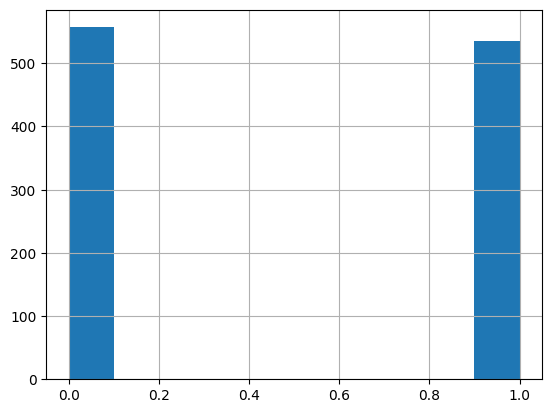

In [ ]:
labels = [data.y.item() for i, data in enumerate(train_data)]
df = pd.DataFrame(labels, columns=["Labels"])
df["Labels"].hist()

In [ ]:
#looking at the details of the first graph
def sample_graph(sample):
  data_sample = train_data[sample]

  print(data_sample)
  print(f"Number of nodes in the first graph: {data_sample.num_nodes}")
  print(f"Number of features in the first graph: {data_sample.num_features}")
  print(f"Number of edges in the first graph: {data_sample.num_edges}")
  print(f'Average node degree: {2*data_sample.num_edges / data_sample.num_nodes:.2f}')
  G = nx.Graph()
  edge_list = data_sample.edge_index.t().tolist()
  G.add_edges_from(edge_list)
  nx.draw(G, with_labels=False, node_size = 60, node_color = '#1f78b4', edge_color = '#969696', width = 1.5)

Data(x=[125, 768], edge_index=[2, 124], y=[1])
Number of nodes in the first graph: 125
Number of features in the first graph: 768
Number of edges in the first graph: 124
Average node degree: 1.98


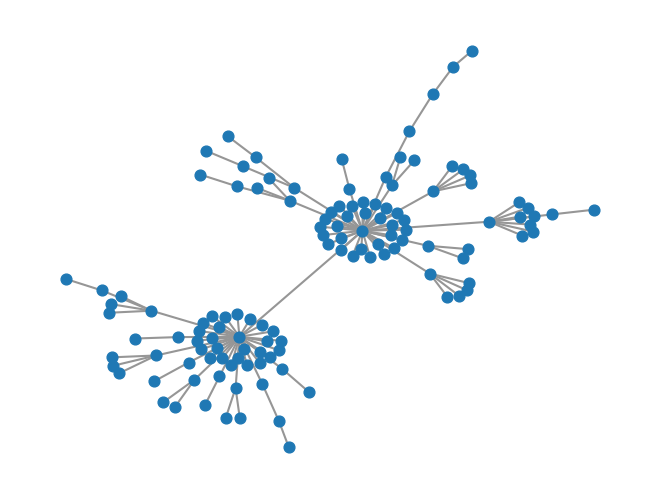

In [ ]:
sample_graph(1)

In [ ]:
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=args.batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False)
# batch maps each node to its respective graph in the batch
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[3621, 310], edge_index=[2, 3557], y=[64], batch=[3621], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[3669, 310], edge_index=[2, 3605], y=[64], batch=[3669], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(x=[3920, 310], edge_index=[2, 3856], y=[64], batch=[3920], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(x=[3929, 310], edge_index=[2, 3865], y=[64], batch=[3929], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(x=[4605, 310], edge_index=[2, 4541], y=[64], batch=[4605], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(x=[4408, 310], edge_index=[2, 4344], y=[64], batch=[4408], ptr=[65])

Step 7:
Number of graphs in the current batch: 64
DataBatch(x=[3391, 310], edge_index=[2, 3327], y=[64], batch=[3391], ptr=[65])

Step 8:
Number of graphs in the current batch: 64
DataBatch(x=[4025, 310], edge_index=[2, 

In [ ]:
class MLP(torch.nn.Module):
  def __init__(self, input_channels, hidden_channels, output_channels):
    super(MLP, self).__init__()

    self.input_channels = input_channels
    self.hidden_channels = hidden_channels
    self.output_channels = output_channels

    #transformation on the graph
    self.lin1 = Linear(input_channels, hidden_channels)
    self.lin2 = Linear(hidden_channels, hidden_channels)
    self.lin3 = Linear(hidden_channels, hidden_channels)

    self.linnews = Linear(input_channels, hidden_channels)

    self.lin0 = Linear(hidden_channels, hidden_channels)
    self.lin = Linear(2*hidden_channels, output_channels) #classifier

    self.reset_parameters()
    
  def reset_parameters(self):
    self.lin1.reset_parameters()
    self.lin2.reset_parameters()
    self.lin3.reset_parameters()
    self.linnews.reset_parameters()
    self.lin0.reset_parameters()
    self.lin.reset_parameters()
    

  def forward(self, x, batch):
    h = self.lin1(x).relu()
    #h = F.dropout(h, p=args.dropout_ratio, training=self.training)
    h = self.lin2(h).relu()
    #h = F.dropout(h, p=args.dropout_ratio, training=self.training)
    h = self.lin3(h).relu()

    h = global_max_pool(h, batch)

    h = self.lin0(h).relu()

    root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
    root = torch.cat([root.new_zeros(1), root + 1], dim=0)
    # root is e.g. [   0,   14,   94,  171,  230,  302, ... ]
    #we are getting the features of the root node
    news = x[root]
    news = self.linnews(news).relu()
    out = self.lin(torch.cat([h, news], dim=-1))

    return torch.sigmoid(out)

MLP(train_data.num_features, args.hidden_channels, 1)

MLP(
  (lin1): Linear(in_features=310, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=128, bias=True)
  (lin3): Linear(in_features=128, out_features=128, bias=True)
  (linnews): Linear(in_features=310, out_features=128, bias=True)
  (lin0): Linear(in_features=128, out_features=128, bias=True)
  (lin): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
class GCN(torch.nn.Module):
  def __init__(self, input_channels, hidden_channels, output_channels, num_gnn_layers):
    super(GCN, self).__init__()

    self.input_channels = input_channels
    self.hidden_channels = hidden_channels
    self.output_channels = output_channels
    self.num_layers = num_gnn_layers

    self.convs = torch.nn.ModuleList()
    #self.bns = torch.nn.ModuleList()

    for layer in range(num_gnn_layers):
      self.convs.append(GCNConv(input_channels, hidden_channels))
      #self.bns.append(BatchNorm1d(hidden_channels))

    #self.lin1 = Linear(hidden_channels, hidden_channels) #after convolutions

    self.linnews = Linear(input_channels, hidden_channels)

    self.lin2 = Linear(hidden_channels, hidden_channels) #after max pooling
    self.lin3 = Linear(2*hidden_channels, output_channels)

    self.reset_parameters()

  def reset_parameters(self):
    for conv in self.convs:
        conv.reset_parameters()
    #for bn in self.bns:
        #bn.reset_parameters()
    #self.lin1.reset_parameters()
    self.linnews.reset_parameters()
    self.lin2.reset_parameters()
    self.lin3.reset_parameters()

  def forward(self, x, adj, batch):
    for idx in range(len(self.convs)):
      h = self.convs[idx](x, adj).relu()
      #h = self.bns[idx](h)
      #h = F.relu(h)
    
    #h = self.lin1(h).relu()
    #h= F.relu(h)

    h = global_max_pool(h, batch)
    h = self.lin2(h).relu()

    root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
    root = torch.cat([root.new_zeros(1), root + 1], dim=0)
    news = x[root]
    news = self.linnews(news).relu()

    out = self.lin3(torch.cat([h, news], dim=-1))

    return torch.sigmoid(out)

GCN(train_data.num_features, args.hidden_channels, 1, 3)

GCN(
  (convs): ModuleList(
    (0-2): 3 x GCNConv(310, 128)
  )
  (linnews): Linear(in_features=310, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=128, bias=True)
  (lin3): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
class GraphSage(torch.nn.Module):
  def __init__(self, input_channels, hidden_channels, output_channels):
    super(GraphSage, self).__init__()
    
    self.input_channels = input_channels
    self.hidden_channels = hidden_channels
    self.output_channels = output_channels

    self.sage1 = SAGEConv(input_channels, hidden_channels, normalize=True)
    #self.bn1 = BatchNorm1d(hidden_channels)
    self.sage2 = SAGEConv(hidden_channels, hidden_channels, normalize = True)
    self.sage3 = SAGEConv(hidden_channels, hidden_channels, normalize = True)
    #self.bn2 = BatchNorm1d(hidden_channels)

    #self.lin1 = Linear(hidden_channels, hidden_channels) #after convolutions

    self.linnews = Linear(input_channels, hidden_channels)

    self.lin2 = Linear(hidden_channels, hidden_channels) #after max pooling
    self.lin3 = Linear(2*hidden_channels, output_channels)

    self.reset_parameters()
    
  def reset_parameters(self):
    self.sage1.reset_parameters()
    self.sage2.reset_parameters()
    self.sage3.reset_parameters()
    #self.bn1.reset_parameters()
    #self.lin1.reset_parameters()
    self.linnews.reset_parameters()
    self.lin2.reset_parameters()
    self.lin3.reset_parameters()

  def forward(self, x, adj, batch):
    h = self.sage1(x, adj).relu()
    h = self.sage2(h, adj).relu()
    h = self.sage3(h, adj).relu()
    #h = F.relu(self.bn1(h))
    #h = self.sage2(h, adj)
    #h = F.relu(self.bn2(h))
    
    #h = self.lin1(h)
    #h= F.relu(h)

    h = global_max_pool(h, batch)
    h = self.lin2(h).relu()

    root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
    root = torch.cat([root.new_zeros(1), root + 1], dim=0)
    news = x[root]
    news = self.linnews(news).relu()

    out = self.lin3(torch.cat([h, news], dim=-1))

    return torch.sigmoid(out)

GraphSage(train_data.num_features, args.hidden_channels, 1)

GraphSage(
  (sage1): SAGEConv(310, 128, aggr=mean)
  (sage2): SAGEConv(128, 128, aggr=mean)
  (sage3): SAGEConv(128, 128, aggr=mean)
  (linnews): Linear(in_features=310, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=128, bias=True)
  (lin3): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
class GAT(torch.nn.Module):
  def __init__(self, input_channels, hidden_channels, output_channels):
    super(GAT, self).__init__()
    
    self.input_channels = input_channels
    self.hidden_channels = hidden_channels
    self.output_channels = output_channels

    self.Gatconv1 = GATConv(input_channels, hidden_channels)
    self.Gatconv2 = GATConv(hidden_channels, hidden_channels)
    self.Gatconv3 = GATConv(hidden_channels, hidden_channels)

    self.linnews = Linear(input_channels, hidden_channels)
    self.lin0 = Linear(hidden_channels, hidden_channels)
    self.lin1 = Linear(2*hidden_channels, output_channels)

    self.reset_parameters()

  def reset_parameters(self):
    self.Gatconv1.reset_parameters()
    self.Gatconv2.reset_parameters()
    self.Gatconv3.reset_parameters()
    self.linnews.reset_parameters()
    self.lin0.reset_parameters()
    self.lin1.reset_parameters()

  def forward(self, x, adj, batch):
    h = self.Gatconv1(x, adj).relu()
    h = self.Gatconv2(h, adj).relu()
    h = self.Gatconv3(h, adj).relu()

    h = global_max_pool(h, batch)
    h = self.lin0(h).relu()

    root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
    root = torch.cat([root.new_zeros(1), root + 1], dim=0)
    news = x[root]
    news = self.linnews(news).relu()

    out = self.lin1(torch.cat([h, news], dim=-1))

    return torch.sigmoid(out)

GAT(train_data.num_features, args.hidden_channels, 1)

GAT(
  (Gatconv1): GATConv(310, 128, heads=1)
  (Gatconv2): GATConv(128, 128, heads=1)
  (Gatconv3): GATConv(128, 128, heads=1)
  (linnews): Linear(in_features=310, out_features=128, bias=True)
  (lin0): Linear(in_features=128, out_features=128, bias=True)
  (lin1): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
class Graph_Isomorphism_Network(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels, num_layers):
      super(Graph_Isomorphism_Network, self).__init__()

      self.input_channels = input_channels
      self.hidden_channels = hidden_channels
      self.output_channels = output_channels
      self.num_layers = num_layers

      self.gnn1 = GIN(input_channels, hidden_channels, num_layers)
      #self.bn1= BatchNorm1d(hidden_channels)
      #self.gnn2 = GIN(hidden_channels, hidden_channels, num_layers)
      #self.bn2= BatchNorm1d(hidden_channels)
      #self.gnn3 = GIN(hidden_channels, hidden_channels, num_layers)

      #self.lin1 = Linear(hidden_channels, hidden_channels)

      self.linnews = Linear(input_channels, hidden_channels)

      self.lin2 = Linear(hidden_channels, hidden_channels) #after max pooling
      self.lin3 = Linear(2*hidden_channels, output_channels)

      self.reset_parameters()
      
    def reset_parameters(self):
      self.gnn1.reset_parameters()
      #self.bn1.reset_parameters()
      #self.gnn2.reset_parameters()
      #self.bn2.reset_parameters()
      #self.gnn3.reset_parameters()
      #self.lin1.reset_parameters()
      self.linnews.reset_parameters()
      self.lin2.reset_parameters()
      self.lin3.reset_parameters()

    def forward(self, x, adj, batch):
      h = self.gnn1(x, adj).relu()
      #h = F.relu(self.bn1(h))
      #h = self.gnn2(h, adj).relu()
      #h = F.relu(self.bn2(h))
      #h = self.gnn3(h, adj).relu()
          
      #h = self.lin1(h)
      #h= F.relu(h)

      h = global_max_pool(h, batch)
      #h = F.dropout(h, p=0.5, training=self.training)
      h = self.lin2(h).relu()

      root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
      root = torch.cat([root.new_zeros(1), root + 1], dim=0)
      news = x[root]
      news = self.linnews(news).relu()

      out = self.lin3(torch.cat([h, news], dim=-1))

      return torch.sigmoid(out)

Graph_Isomorphism_Network(train_data.num_features, args.hidden_channels, 1, 2)

Graph_Isomorphism_Network(
  (gnn1): GIN(310, 128, num_layers=2)
  (linnews): Linear(in_features=310, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=128, bias=True)
  (lin3): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if args.model == 'gcn':
    model = GCN(train_data.num_features, args.hidden_channels, 1, 1).to(device)
    model.reset_parameters()
elif args.model == 'sage':
    model = GraphSage(train_data.num_features, args.hidden_channels, 1).to(device)
    model.reset_parameters()
elif args.model == 'gat':
    model = GAT(train_data.num_features, args.hidden_channels, 1).to(device)
    model.reset_parameters()
elif args.model == 'gin':
    model = Graph_Isomorphism_Network(train_data.num_features, args.hidden_channels, 1, 3).to(device)
    model.reset_parameters()
else:
    model = MLP(train_data.num_features, args.hidden_channels, 1).to(device)
    model.reset_parameters()
    
optimizer = torch.optim.Adam(model.parameters(), lr = args.lr, weight_decay = args.weight_decay)
loss_fnc = torch.nn.BCELoss()

torch.manual_seed(args.seed)

def train():
    model.train()
    num_correct = num_examples = total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        if args.model in ['gcn', 'sage', 'gat', 'gin']:
          out = model(data.x, data.edge_index, data.batch)
        else:
          out = model(data.x, data.batch)
        loss = loss_fnc(out.view(-1), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        preds = torch.round(out.view(-1)).long()
        num_correct += (preds == data.y.view(-1).long()).sum().item()
        num_examples += data.num_graphs

    accuracy = num_correct / num_examples
    return total_loss / len(train_loader.dataset), accuracy

@torch.no_grad()
def compute_test(loader):
    model.eval()
    num_correct = num_examples = total_loss = 0
    all_preds = []
    all_targets = []
    for data in loader:
        data = data.to(device)
        if args.model in ['gcn', 'sage', 'gat', 'gin']:
          out = model(data.x, data.edge_index, data.batch)
        else:
          out = model(data.x, data.batch)  
        loss = loss_fnc(out.view(-1), data.y.float())
        total_loss += loss.item() * data.num_graphs
        preds = torch.round(out.view(-1)).long()
        all_preds.append(preds.cpu())
        all_targets.append(data.y.view(-1).cpu())
        num_correct += (preds == data.y.view(-1).long()).sum().item()
        num_examples += data.num_graphs
    
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    # Calculate Metrics
    accuracy = num_correct / num_examples
    f1 = f1_score(all_targets, all_preds, average='macro')

    return total_loss / len(loader.dataset), accuracy, f1


In [ ]:
import numpy as np

results_file = 'results.csv'
try:
    results_df = pd.read_csv(results_file)
except FileNotFoundError:
    results_df = pd.DataFrame(columns=["Model", "Test_Accuracy", "Acc_std", "Test_F1_Score", "F1_std", "Trainable_Parameters"])

def main_experiment():
    best_acc = 0
    best_model = None
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    counter = 0

    for epoch in range(1, 1 + args.epochs):
        train_loss, train_acc = train()
        val_loss, val_acc, val_f1 = compute_test(val_loader)
        print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.2f} | TrainAcc: {train_acc:.2f} '
              f'ValLoss: {val_loss:.2f} | ValAcc: {val_acc:.2f} | ValF1: {val_f1:.2f}')
        
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        current_acc = val_acc

        if current_acc > best_acc + args.min_delta:
            best_acc = current_acc
            best_model = copy.deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1

        if counter >= args.patience:
            print(f"Validation performance did not improve by at least {args.min_delta:.3f} for {args.patience} epochs. Stopping training...")
            print(f"Best validation accuracy: {best_acc:.2f}")
            break
    print("========================================================================")
    print()
    model.load_state_dict(best_model)
    _, acc_test, f1_test = compute_test(test_loader)
    print(f'Test Accuracy: {acc_test:.2f}, Test F1 Score: {f1_test:.2f}, Model: {args.model}')
    #print(f'Number of trainable parameters: {count_parameters(model)}')

    #new_result = {"Model": args.model, "Test_Accuracy": acc_test, "Test_F1_Score": f1_test, "Trainable_Parameters": count_parameters(model)}
    #results_df = results_df.append(new_result, ignore_index=True)
    #results_df.to_csv(results_file, index=False)

    return acc_test, f1_test, train_loss_history, train_acc_history, val_loss_history, val_acc_history

num_runs = 5
test_accuracies = []
f1_scores = []
for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    model.reset_parameters()
    test_acc, f1_sco, _, _, _, _ = main_experiment()
    test_accuracies.append(test_acc)
    f1_scores.append(f1_sco)

mean_acc = np.mean(test_accuracies)
std_acc = np.std(test_accuracies)
f1_score_mean = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print(f"Mean test accuracy over {num_runs} runs: {mean_acc:.3f} +- {std_acc:.3f}\n Mean F1 Score over {num_runs} runs: {f1_score_mean:.3f} +- {std_f1:.3f}\n No. of parameters: {count_parameters(model)}")
result = {"Model": args.model, "Test_Accuracy": mean_acc, "Acc_std":std_acc, "Test_F1_Score": f1_score_mean, "F1_std": std_f1, "Trainable_Parameters": count_parameters(model)}
results_df = results_df.append(result, ignore_index=True)
results_df.to_csv(results_file, index=False)    

Run 1/5
Epoch: 01 |  TrainLoss: 0.84 | TrainAcc: 0.49 ValLoss: 0.70 | ValAcc: 0.49 | ValF1: 0.33
Epoch: 02 |  TrainLoss: 0.70 | TrainAcc: 0.51 ValLoss: 0.69 | ValAcc: 0.49 | ValF1: 0.33
Epoch: 03 |  TrainLoss: 0.69 | TrainAcc: 0.51 ValLoss: 0.68 | ValAcc: 0.49 | ValF1: 0.33
Epoch: 04 |  TrainLoss: 0.72 | TrainAcc: 0.50 ValLoss: 0.68 | ValAcc: 0.72 | ValF1: 0.71
Epoch: 05 |  TrainLoss: 0.69 | TrainAcc: 0.56 ValLoss: 0.67 | ValAcc: 0.51 | ValF1: 0.38
Epoch: 06 |  TrainLoss: 0.68 | TrainAcc: 0.53 ValLoss: 0.66 | ValAcc: 0.92 | ValF1: 0.92
Epoch: 07 |  TrainLoss: 0.68 | TrainAcc: 0.68 ValLoss: 0.66 | ValAcc: 0.51 | ValF1: 0.34
Epoch: 08 |  TrainLoss: 0.65 | TrainAcc: 0.66 ValLoss: 0.72 | ValAcc: 0.51 | ValF1: 0.34
Epoch: 09 |  TrainLoss: 0.64 | TrainAcc: 0.64 ValLoss: 0.59 | ValAcc: 0.73 | ValF1: 0.72
Epoch: 10 |  TrainLoss: 0.57 | TrainAcc: 0.74 ValLoss: 0.63 | ValAcc: 0.51 | ValF1: 0.34
Epoch: 11 |  TrainLoss: 0.54 | TrainAcc: 0.74 ValLoss: 0.46 | ValAcc: 0.93 | ValF1: 0.93
Epoch: 12 |  

<ipython-input-14-5f5345b046eb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result, ignore_index=True)


Epoch: 01 |  TrainLoss: 0.36 | TrainAcc: 0.86 ValLoss: 0.31 | ValAcc: 0.93 | ValF1: 0.93
Epoch: 02 |  TrainLoss: 0.31 | TrainAcc: 0.90 ValLoss: 0.40 | ValAcc: 0.77 | ValF1: 0.76
Epoch: 03 |  TrainLoss: 0.32 | TrainAcc: 0.89 ValLoss: 0.30 | ValAcc: 0.92 | ValF1: 0.92
Epoch: 04 |  TrainLoss: 0.30 | TrainAcc: 0.89 ValLoss: 0.27 | ValAcc: 0.93 | ValF1: 0.93
Epoch: 05 |  TrainLoss: 0.28 | TrainAcc: 0.90 ValLoss: 0.58 | ValAcc: 0.69 | ValF1: 0.67
Epoch: 06 |  TrainLoss: 0.30 | TrainAcc: 0.88 ValLoss: 0.25 | ValAcc: 0.94 | ValF1: 0.94
Epoch: 07 |  TrainLoss: 0.26 | TrainAcc: 0.91 ValLoss: 0.28 | ValAcc: 0.90 | ValF1: 0.90
Epoch: 08 |  TrainLoss: 0.25 | TrainAcc: 0.91 ValLoss: 0.41 | ValAcc: 0.78 | ValF1: 0.76
Epoch: 09 |  TrainLoss: 0.27 | TrainAcc: 0.90 ValLoss: 0.41 | ValAcc: 0.78 | ValF1: 0.77
Epoch: 10 |  TrainLoss: 0.28 | TrainAcc: 0.89 ValLoss: 0.23 | ValAcc: 0.95 | ValF1: 0.95
Epoch: 11 |  TrainLoss: 0.26 | TrainAcc: 0.91 ValLoss: 0.73 | ValAcc: 0.58 | ValF1: 0.48
Epoch: 12 |  TrainLos

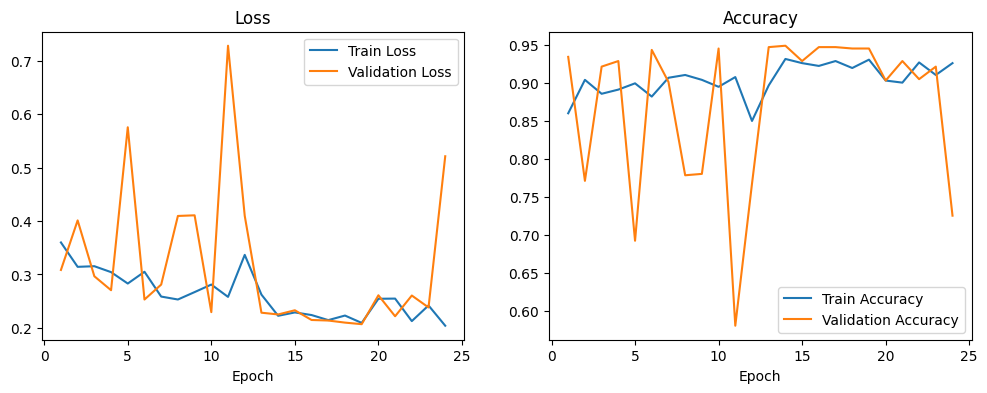

In [ ]:
def plot_history(train_loss_history, train_acc_history, val_loss_history, val_acc_history):
    epochs = len(train_loss_history)
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].plot(range(1, epochs+1), train_loss_history, label='Train Loss')
    axs[0].plot(range(1, epochs+1), val_loss_history, label='Validation Loss')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend()

    axs[1].plot(range(1, epochs+1), train_acc_history, label='Train Accuracy')
    axs[1].plot(range(1, epochs+1), val_acc_history, label='Validation Accuracy')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend()

    plt.show()

# plotting the first run
_, _, train_loss_history, train_acc_history, val_loss_history, val_acc_history = main_experiment()
plot_history(train_loss_history, train_acc_history, val_loss_history, val_acc_history)